# Hyper parameter tuning for ML

220831, by wygo

- [ref](https://bit.ly/3PkGBHc)

In [1]:
# install
# 설치 후 런타임 재시작 해야함!! restart runtime 버튼을 누르고 아래 셀들을 실행!
!pip install matplotlib==3.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 3.9 MB/s 
     |████████████████████████████████| 957 kB 62.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


* **visualization setting**

In [1]:
# visualization settings
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")
sns.set_palette("colorblind")

# Data Preparation: penguins dataset


* **stratified data sampling**

In [2]:
df_peng = sns.load_dataset("penguins")
df_peng = df_peng.dropna().reset_index(drop=True)    # 결측치 제거 후 index reset
df_peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [3]:
from sklearn.model_selection import train_test_split

y = df_peng["body_mass_g"]
X = df_peng.drop("body_mass_g", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify=X[["species", "island", "sex"]])

# Pipeline

* **pipeline with Random Forest, LightGBM, XGBoost**

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

def get_model(method="rf",
              cat_features=["species", "island", "sex"], 
              num_features=["bill_length_mm", "bill_depth_mm", "flipper_length_mm"],
              **kwargs):
    # 1-1.categorical feature에 one-hot encoding 적용
    cat_transformer = OneHotEncoder()

    # 1-2.numerical feature는 standard scaler 적용
    num_transformer = StandardScaler()

    # 2. 인자 종류별 전처리 적용
    preprocessor = ColumnTransformer([("cat", cat_transformer, cat_features), 
                                    ("num", num_transformer, num_features)])

    # 3. 전처리 후 입력된 방법론 적용
    if method == "rf":
        ml = ("ml", RandomForestRegressor(**kwargs))
    elif method == "lgbm":
        ml = ("ml", LGBMRegressor(**kwargs))
    elif method == "xgb":
        ml = ("ml", XGBRegressor(**kwargs))

    pipeline = Pipeline(steps=[("preprocessor", preprocessor), 
                               ml])
    
    return pipeline

In [5]:
from sklearn import set_config
set_config(display='diagram')

In [6]:
from sklearn.ensemble import RandomForestRegressor

model = get_model(method="rf")

In [7]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['species', 'island', 'sex']),
                                                 ('num', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm'])])),
                ('ml', RandomForestRegressor())])

* **Decision Tree Visualizer**

In [8]:
import io
import pydot
from IPython.core.display import Image
from sklearn.tree import export_graphviz


def draw_decision_tree(model, 
                       feature_names=["bill_length_mm", "bill_depth_mm", "flipper_length_mm",
                                      "species_Adelie", "species_Chinstrap", "species_Gentoo", 
                                      "island_Biscoe", "island_Dream", "island_Torgersen", 
                                      "sex_Female", "sex_Male"]):
    dot_buf = io.StringIO()
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0]
    image = graph.create_png()
    return Image(image)

100


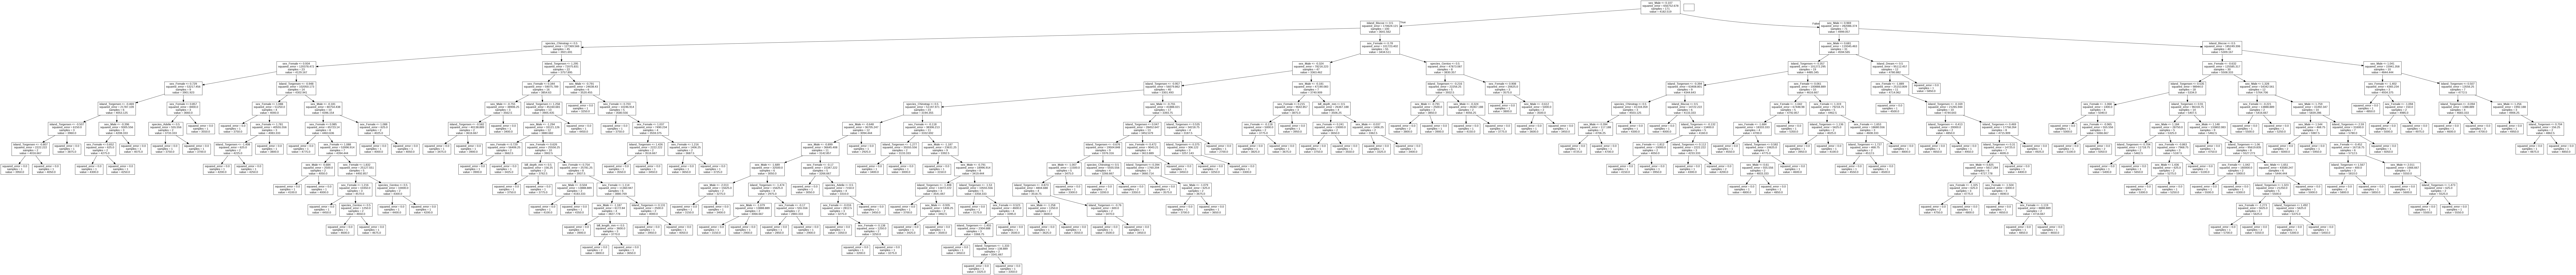

In [9]:
dts = model["ml"].estimators_
print(len(dts))
draw_decision_tree(dts[2])

In [10]:
model["ml"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

* **Visualization code: parity plot**

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

c_train = "g"
c_val = "m"

def get_parity(y_train, y_val, y_pred_train, y_pred_val):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5.5), constrained_layout=True, sharex=True, sharey=True)
    for ax, y_true, y_pred, c, title in zip(axs, [y_train, y_val], [y_pred_train, y_pred_val], [c_train, c_val], ["train", "valid"]):
        ax.scatter(y_true, y_pred, c=c)
        ax.set_xlabel("true", color="gray", labelpad=12)
        if ax == axs[0]:
            ax.set_ylabel("prediction", color="gray", labelpad=12)
        ax.set_title(title, color="gray", pad=12)

        r2 = r2_score(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)

        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        limmin = min(xmin, ymin)
        limmax = max(xmax, ymax)
        ax.plot([limmin, limmax], [limmin, limmax], c="k", alpha=0.5)
        ax.set_xlim(limmin, limmax)
        ax.set_ylim(limmin, limmax)

        ax.text(0.95, 0.05, f"R2 = {r2:.3f}\nRMSE = {rmse:.3f}", ha="right", transform=ax.transAxes, fontsize=16)
    return fig, r2

* **Test Run**

In [12]:
import time

def timelog(fn):
    def wrap_fn(*args, **kwargs):
        time_start = time.time()
        result = fn(*args, **kwargs)
        time_end = time.time()
        print(f"# running time: {time_end-time_start:.2f} sec.")
        return result
    return wrap_fn

@timelog
def fit_pipeline(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# running time: 0.26 sec.


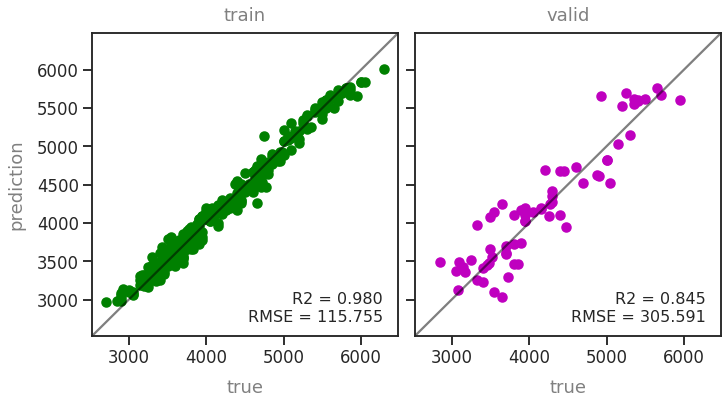

In [13]:
import time

# model 생성
model_default = get_model(method="rf", random_state=0)

# model 학습 & 학습 시간 측정
time_start = time.time()
model = model_default.fit(X_train, y_train)
time_end = time.time()
print(f"# running time: {time_end-time_start:.2f} sec.")

# model 예측
y_pred_train = model_default.predict(X_train)
y_pred_val = model_default.predict(X_val)

fig, r2_default = get_parity(y_train, y_val, y_pred_train, y_pred_val)

# Hyperparameter Optimization

* **(1) Grid Search**

In [14]:
from sklearn.model_selection import GridSearchCV

# parameter grid
params = {"ml__n_estimators": [100, 200, 300],
          "ml__max_depth": [3, 5, 10],
          "ml__min_samples_leaf": [1, 3, 5, 7, 10],
          "ml__max_features": ["auto", "sqrt", "log2"]
          }

# GridSearchCV Pipeline 생성
model = get_model(method="rf", random_state=0)
gscv = GridSearchCV(model, param_grid=params, scoring="r2", refit="r2")

# GridSearchCV 학습 & 학습 시간 측정
time_start = time.time()
gscv.fit(X_train, y_train)
time_end = time.time()
time_gscv = time_end-time_start
print(f"# running time: {time_gscv:.2f} sec.")

gscv

# running time: 170.77 sec.


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         ['species',
                                                                          'island',
                                                                          'sex']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['bill_length_mm',
                                                                          'bill_depth_mm',
                                                                          'flipper_length_mm'])])),
                                       ('ml',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'ml__max_depth': [3, 5, 10],
                         'ml__max_features': ['auto', 'sqrt', 'log2'],
                         'ml__min_samples_leaf': [1, 3, 5, 7, 10],
                         'ml__n_estimators': [100, 200, 300]},
             refit='r2', scoring='r2')

In [15]:
import pandas as pd

pd.DataFrame.from_dict(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.107710,0.004533,0.010765,0.001152,3,auto,1,100,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.853428,0.738123,0.881694,0.809378,0.880477,0.832620,0.054040,95
1,0.208427,0.007859,0.016805,0.001656,3,auto,1,200,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.852062,0.746097,0.884198,0.812393,0.881906,0.835331,0.051626,79
2,0.310153,0.006134,0.021580,0.000452,3,auto,1,300,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.853165,0.747328,0.885328,0.810411,0.881561,0.835558,0.051614,78
3,0.108874,0.005898,0.009746,0.000261,3,auto,3,100,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.853615,0.723849,0.880539,0.803692,0.879925,0.828324,0.059246,114
4,0.216811,0.006255,0.018357,0.003349,3,auto,3,200,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.852142,0.736474,0.883317,0.807161,0.881639,0.832147,0.055218,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.192303,0.004879,0.017499,0.003745,10,log2,7,200,"{'ml__max_depth': 10, 'ml__max_features': 'log...",0.848645,0.797554,0.885965,0.826841,0.868964,0.845594,0.031128,31
131,0.294047,0.012662,0.022666,0.002117,10,log2,7,300,"{'ml__max_depth': 10, 'ml__max_features': 'log...",0.850054,0.794367,0.886946,0.826034,0.868280,0.845136,0.032405,33
132,0.099566,0.001050,0.011160,0.002907,10,log2,10,100,"{'ml__max_depth': 10, 'ml__max_features': 'log...",0.842675,0.786383,0.877673,0.815024,0.856516,0.835654,0.031948,76
133,0.197534,0.006227,0.017436,0.003342,10,log2,10,200,"{'ml__max_depth': 10, 'ml__max_features': 'log...",0.845494,0.798104,0.873584,0.819815,0.855593,0.838518,0.026657,55


In [16]:
# best hyperparameters
print(gscv.best_params_)

# best score
print(gscv.best_score_)
gscv_best = gscv.best_score_

{'ml__max_depth': 5, 'ml__max_features': 'sqrt', 'ml__min_samples_leaf': 1, 'ml__n_estimators': 100}
0.8530842908162327


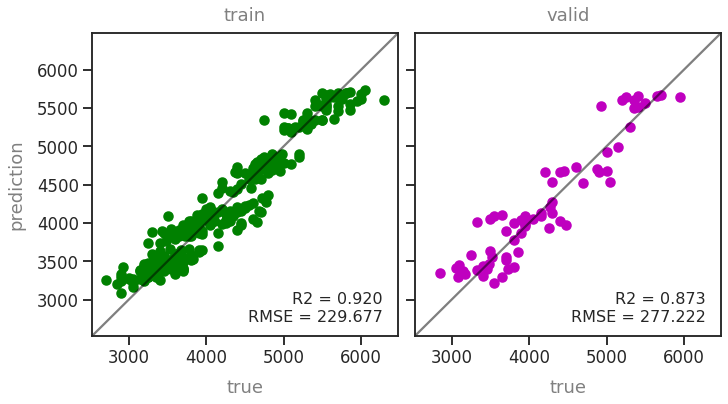

In [17]:
y_pred_train = gscv.predict(X_train)
y_pred_val = gscv.predict(X_val)
fig, r2_gsval = get_parity(y_train, y_val, y_pred_train, y_pred_val)

* **(2) Random Search CV**

In [18]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# parameter distribution
params = {"ml__n_estimators": stats.randint(100, 300),   # [100, 200, 300]
          "ml__max_depth": stats.randint(3, 10),         # [3, 5, 10],
          "ml__min_samples_leaf": stats.randint(1, 10),  # [1, 3, 5, 7, 10]
          "ml__max_features": stats.uniform(0, 1),       # ["auto", "sqrt", "log2"]
          }

# RandomizedSearchCV Pipeline 생성
model = get_model(method="rf", random_state=0)
rscv = RandomizedSearchCV(model, param_distributions=params, # param_grid
                          n_iter=30,                         # number of HP sampling
                          scoring="r2", refit="r2")

# RandomizedSearchCV 학습 & 학습 시간 측정
time_start = time.time()
rscv.fit(X_train, y_train)
time_end = time.time()
time_rscv = time_end-time_start
print(f"# running time: {time_rscv:.2f} sec.")

# running time: 33.79 sec.


In [19]:
pd.DataFrame.from_dict(rscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.200176,0.005680,0.018741,0.003275,7,0.085044,3,202,"{'ml__max_depth': 7, 'ml__max_features': 0.085...",0.834440,0.786745,0.887536,0.838393,0.881167,0.845656,0.036507,6
1,0.257230,0.004643,0.021756,0.003375,9,0.234188,5,264,"{'ml__max_depth': 9, 'ml__max_features': 0.234...",0.847456,0.791104,0.885701,0.832586,0.869890,0.845347,0.032681,8
2,0.219974,0.005337,0.020473,0.003474,6,0.003323,9,232,"{'ml__max_depth': 6, 'ml__max_features': 0.003...",0.825819,0.800799,0.852824,0.804248,0.837894,0.824317,0.019774,27
3,0.232014,0.004776,0.022337,0.003282,3,0.005246,3,250,"{'ml__max_depth': 3, 'ml__max_features': 0.005...",0.816048,0.795826,0.834536,0.806137,0.829243,0.816358,0.014301,30
4,0.313066,0.005111,0.022407,0.001528,6,0.682663,5,299,"{'ml__max_depth': 6, 'ml__max_features': 0.682...",0.851815,0.722644,0.888068,0.829033,0.894304,0.837173,0.062051,17
5,0.186037,0.008672,0.014987,0.000439,5,0.427314,7,186,"{'ml__max_depth': 5, 'ml__max_features': 0.427...",0.855973,0.778880,0.887926,0.827802,0.873291,0.844774,0.038551,9
6,0.138577,0.003477,0.012416,0.000424,4,0.055352,9,147,"{'ml__max_depth': 4, 'ml__max_features': 0.055...",0.819817,0.795387,0.845754,0.803679,0.832179,0.819363,0.018340,29
7,0.201276,0.003217,0.015314,0.000180,7,0.752477,9,198,"{'ml__max_depth': 7, 'ml__max_features': 0.752...",0.851570,0.739796,0.885539,0.812848,0.880332,0.834017,0.053728,21
8,0.210151,0.005720,0.018613,0.002088,8,0.069811,8,225,"{'ml__max_depth': 8, 'ml__max_features': 0.069...",0.829791,0.804089,0.866056,0.815683,0.847455,0.832615,0.022122,22
9,0.157402,0.005228,0.014536,0.000975,6,0.103687,1,158,"{'ml__max_depth': 6, 'ml__max_features': 0.103...",0.827662,0.764732,0.890507,0.848599,0.898467,0.845993,0.048335,4


In [20]:
# best hyperparameters
print(rscv.best_params_)

# best score
print(rscv.best_score_)
rscv_best = rscv.best_score_

{'ml__max_depth': 4, 'ml__max_features': 0.43913902793713755, 'ml__min_samples_leaf': 1, 'ml__n_estimators': 255}
0.8519235740041419


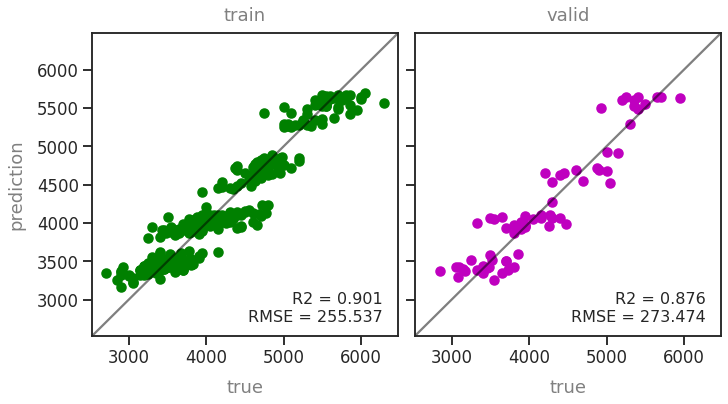

In [21]:
y_pred_train = rscv.predict(X_train)
y_pred_val = rscv.predict(X_val)
fig, r2_rsval = get_parity(y_train, y_val, y_pred_train, y_pred_val)

* **(3) Bayesian Search CV**

In [22]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 3.7 MB/s 


In [23]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

# parameter distribution
params = {"ml__n_estimators": Integer(100, 300),        # [100, 200, 300]
          "ml__max_depth": Integer(3, 10),              # [3, 5, 10],
          "ml__min_samples_leaf": Integer(1, 10),       # [1, 3, 5, 7, 10]
          "ml__max_features": Categorical(["auto", "sqrt", "log2"]) # ["auto", "sqrt", "log2"]
          }

# BayesSearchCV Pipeline 생성
model = get_model(method="rf", random_state=0)
bscv = BayesSearchCV(model, search_spaces=params,  # param_grid
                     n_iter=30,                    # number of HP sampling
                     cv=5,                         # number of folds in CV 
                     scoring="r2", refit="r2")

# BayesSearchCV 학습 & 학습 시간 측정
time_start = time.time()
bscv.fit(X_train, y_train)
time_end = time.time()
time_bscv = time_end-time_start
print(f"# running time: {time_bscv:.2f} sec.")

# running time: 75.14 sec.


In [24]:
pd.DataFrame.from_dict(bscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.227585,0.003836,0.017316,0.002020,9,auto,8,209,"{'ml__max_depth': 9, 'ml__max_features': 'auto...",0.847537,0.714743,0.890305,0.811057,0.889426,0.830614,0.064987,29
1,0.275163,0.078930,0.021131,0.005658,5,log2,7,209,"{'ml__max_depth': 5, 'ml__max_features': 'log2...",0.849379,0.795126,0.885783,0.827690,0.868416,0.845279,0.031678,15
2,0.160063,0.005802,0.014251,0.001029,3,log2,7,159,"{'ml__max_depth': 3, 'ml__max_features': 'log2...",0.841732,0.797240,0.871033,0.807750,0.849681,0.833487,0.027263,28
3,0.192460,0.004826,0.014960,0.000153,8,log2,2,185,"{'ml__max_depth': 8, 'ml__max_features': 'log2...",0.831425,0.769521,0.892068,0.844354,0.899770,0.847428,0.047048,12
4,0.199410,0.032943,0.016408,0.005237,6,auto,7,161,"{'ml__max_depth': 6, 'ml__max_features': 'auto...",0.843996,0.704458,0.888381,0.813786,0.892464,0.828617,0.068586,30
5,0.128781,0.005919,0.011497,0.000160,9,log2,8,127,"{'ml__max_depth': 9, 'ml__max_features': 'log2...",0.850108,0.794867,0.883305,0.818038,0.867600,0.842784,0.032310,18
6,0.210338,0.005882,0.016778,0.000983,10,sqrt,2,204,"{'ml__max_depth': 10, 'ml__max_features': 'sqr...",0.829189,0.771167,0.891805,0.850033,0.900438,0.848526,0.046751,10
7,0.148111,0.005657,0.013682,0.001989,8,log2,2,141,"{'ml__max_depth': 8, 'ml__max_features': 'log2...",0.830794,0.764669,0.894076,0.843574,0.900406,0.846704,0.049235,13
8,0.519736,0.077671,0.041784,0.007492,8,sqrt,9,262,"{'ml__max_depth': 8, 'ml__max_features': 'sqrt...",0.849294,0.799176,0.881321,0.819575,0.861434,0.842160,0.029373,19
9,0.615764,0.057871,0.057971,0.017719,4,sqrt,7,268,"{'ml__max_depth': 4, 'ml__max_features': 'sqrt...",0.851062,0.796895,0.883600,0.825463,0.864454,0.844295,0.030326,16


In [25]:
# best hyperparameters
print(bscv.best_params_)

# best score
print(bscv.best_score_)
bscv_best = bscv.best_score_

OrderedDict([('ml__max_depth', 6), ('ml__max_features', 'sqrt'), ('ml__min_samples_leaf', 2), ('ml__n_estimators', 226)])
0.8500701537906508


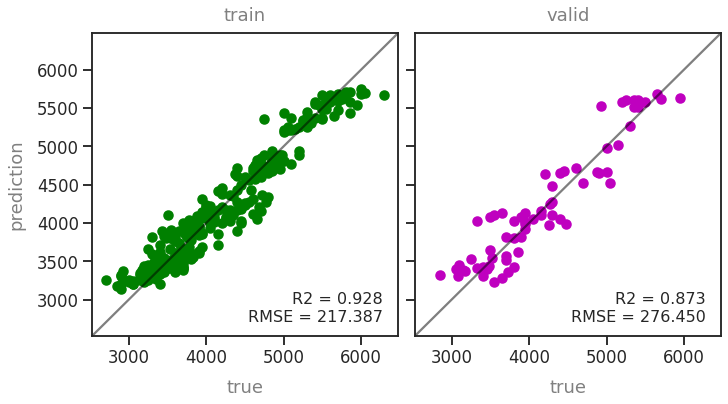

In [26]:
y_pred_train = bscv.predict(X_train)
y_pred_val = bscv.predict(X_val)
fig, r2_bsval = get_parity(y_train, y_val, y_pred_train, y_pred_val)

* **summary**

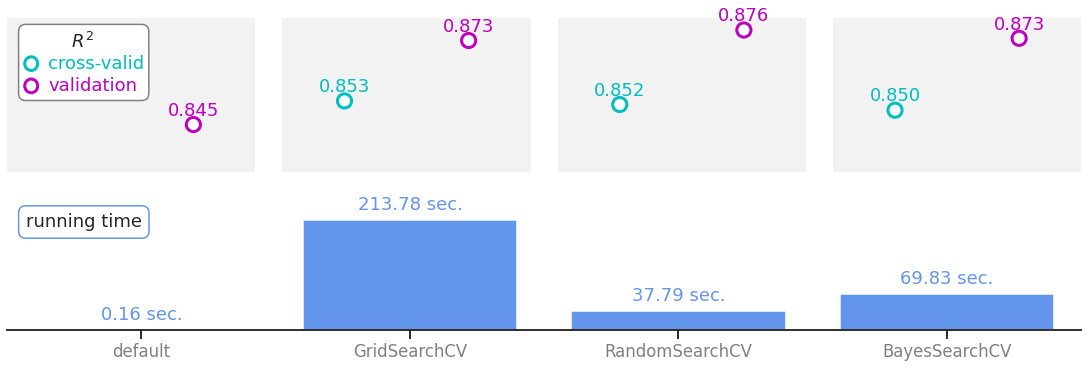

In [27]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

fig = plt.Figure(figsize=(15, 5), constrained_layout=True)
sfigs = fig.subfigures(nrows=2, hspace=0.1)

axs_R2 = sfigs[0].subplots(ncols=4, sharex=True, sharey=True, gridspec_kw={"wspace":0.1})
R2_cvs = [-1, gscv_best, rscv_best, bscv_best]
R2_vals = [r2_default, r2_gsval, r2_rsval, r2_bsval]

for ax, R2_cv, R2_val in zip(axs_R2, R2_cvs, R2_vals):
    ax.scatter([0, 1], [R2_cv, R2_val], fc="w", ec=["c", "m"], lw=3, s=200)
    if ax in axs_R2[1:]:
        ax.text(0, R2_cv+0.003, f"{R2_cv:.3f}", ha="center", color="c")
    ax.text(1, R2_val+0.003, f"{R2_val:.3f}", ha="center", color="m")
    ax.set(xlim=(-0.5, 1.5), ylim=(0.83, 0.88), xticks=[], yticks=[])
    ax.spines[:].set_visible(False)
    ax.set_fc("0.95")

sfigs[0].text(0.02, 0.5, "        $R^2$         \n\n", transform=sfigs[0].transSubfigure, 
           bbox={"boxstyle":"round", "fc":"w", "ec":"gray", "pad":0.4})
marker0 = Ellipse((0.025, 0.65), 0.012, 0.08, ec="c", fc="w", lw=3, zorder=10)
marker1 = Ellipse((0.025, 0.52), 0.012, 0.08, ec="m", fc="w", lw=3, zorder=10)
sfigs[0].add_artist(marker0)
sfigs[0].add_artist(marker1)
sfigs[0].text(0.041, 0.62, "cross-valid", color="c", transform=sfigs[0].transSubfigure)
sfigs[0].text(0.041, 0.49, "validation", color="m", transform=sfigs[0].transSubfigure)


ts = [0.16, 213.78, 37.79, 69.83]
axs_t = sfigs[1].subplots()
axs_t.bar([0, 1, 2, 3], ts, color="cornflowerblue")
axs_t.set(xlim=(-0.5, 3.5), xticks=[0, 1, 2, 3], yticks=[])
axs_t.set_xticklabels(["default", "GridSearchCV", "RandomSearchCV", "BayesSearchCV"], color="gray")
for p in axs_t.patches:
    h = p.get_height()
    x = p.get_x()
    w = p.get_width()
    axs_t.text(x+w/2, h+20, f"{h} sec.", color="cornflowerblue", ha="center")
axs_t.spines[:].set_visible(False)
axs_t.spines["bottom"].set_visible(True)
sfigs[1].text(0.02, 0.8, "running time", transform=sfigs[1].transSubfigure, 
           bbox={"boxstyle":"round", "fc":"w", "ec":"cornflowerblue", "pad":0.4})

display(fig)